In [16]:
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
from sklearn.svm import LinearSVC
from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

# Description

This notebook pulls in and flattens compressed image files, then utilizes a support vector machine to classify. 

I divided into the following sections:

- 1) Image preprocessing
- 2) Hyperparameter optimization and fitting
- 3) Prediction and results

# 1) Image Preprocessing

- The following section reads in data from ./Data_compressed folder and converts the images into a flat numpy array using tensorflow

In [2]:
datagen = ImageDataGenerator(rescale=1./255)

In [3]:
train_data = datagen.flow_from_directory('./Data_compressed/train', 
                                         class_mode='categorical',target_size=(150, 150),color_mode='grayscale')
test_data = datagen.flow_from_directory('./Data_compressed/test', 
                                        class_mode='categorical',target_size=(150, 150),color_mode='grayscale')
val_data = datagen.flow_from_directory('./Data_compressed/val', 
                                       class_mode='categorical', target_size=(150, 150),color_mode='grayscale')

Found 6326 images belonging to 4 classes.
Found 771 images belonging to 4 classes.
Found 38 images belonging to 4 classes.


In [22]:
def image_preprocessing(data):
    num_batches = len(data)
    features_list = []
    labels_list = []

    #Loop through batches of images in each image silo
    for i in range(num_batches):
        pixel_data, label = train_data.next()
        pixel_data_flat = pixel_data.reshape(pixel_data.shape[0], -1)  # Flatten images
        features_list.append(pixel_data_flat)
        labels_list.append(np.argmax(label, axis=1))

    #Compile image data and label data into numpy array
    images_data = np.vstack(features_list) 
    labels = np.concatenate(labels_list)
    return images_data, labels

In [5]:
train_X, train_y = image_preprocessing(train_data)
test_X, test_y = image_preprocessing(test_data)
val_X, val_y = image_preprocessing(val_data)

# 2) Hyperparameter Optimization and Fitting

- The following section utilizes a Support Vector Classifier with a blend of hyperparameters to determine the best estimator

In [24]:
# Create hyperparameter dictionary for reference
grid_params = {"kernel": ["poly", "rbf","sigmoid"],
               "degree": [3, 5, 7],
               "gamma": ["scale", "auto"],
               "coef0": [0.0, 1.0]
}

# Create SVC model instance
svc = SVC()

# Determine best estimator using cross validation
grid_svc_accuracy = GridSearchCV(svc, grid_params, scoring="accuracy")

# Fit the model
grid_svc_accuracy.fit(train_X, train_y)

# Display results
print("Best accuracy estimator: ", grid_svc_accuracy.best_estimator_)
print("Best accuracy estimator: ", grid_svc_accuracy.best_score_)
print("Best accuracy estimator: ", grid_svc_accuracy.best_params_)

Best accuracy estimator:  SVC(coef0=1.0, kernel='poly')
Best accuracy estimator:  0.9405648489843832
Best accuracy estimator:  {'coef0': 1.0, 'degree': 3, 'gamma': 'scale', 'kernel': 'poly'}


# 3) Prediction and Results

- The final section using the fitted model to make predictions against new testing data, displaying results in a confusion matrix

In [23]:
def dashboard(model, X, y, ls = ['COVID-19', 'Normal', 'Pneumonia', 'Tuberculosis'], train=False):
    plt.figure(figsize=(10,10))
    pred = model.predict(X)
    report = pd.DataFrame(classification_report(y, pred, target_names = ls, output_dict=True))
    cm = confusion_matrix(y, pred,normalize="pred")
    if train:
        print("Train Result: \n ================================================")
    else:
        print("Test Result: \n ================================================")
    print(f"Accuracy Score: {accuracy_score(y, pred) * 100:.2f}%")
    print("_______________________________________________")
    print(f"CLASSIFICATION REPORT:\n{report}\n")
    xlab = [x+ " Actual" for x in ls]
    ylab = [y+ " Predicted" for y in ls]
    ax = sns.heatmap(cm, annot=True, cmap='Blues', fmt='.2%', xticklabels= xlab, yticklabels=ylab
                    ,cbar_kws={'format': '%.2f%%'},vmin=0, vmax=1)
    if train:
        ax.set_title('Train Set Confusion Matrix')
    else:
        ax.set_title('Test Set Confusion Matrix')
    cbar = ax.collections[0].colorbar
    cbar.set_ticks([0, .25,0.50, .75, 1])
    cbar.set_ticklabels(['0%', '25%','50%', '75%', '100%'])

Train Result: 
Accuracy Score: 99.27%
_______________________________________________
CLASSIFICATION REPORT:
             COVID-19       Normal    Pneumonia  Tuberculosis  accuracy  \
precision    0.986813     0.993980     0.993316      0.990798  0.992728   
recall       0.976087     0.985086     0.997161      0.993846  0.992728   
f1-score     0.981421     0.989513     0.995235      0.992320  0.992728   
support    460.000000  1341.000000  3875.000000    650.000000  0.992728   

             macro avg  weighted avg  
precision     0.991227      0.992725  
recall        0.988045      0.992728  
f1-score      0.989622      0.992718  
support    6326.000000   6326.000000  



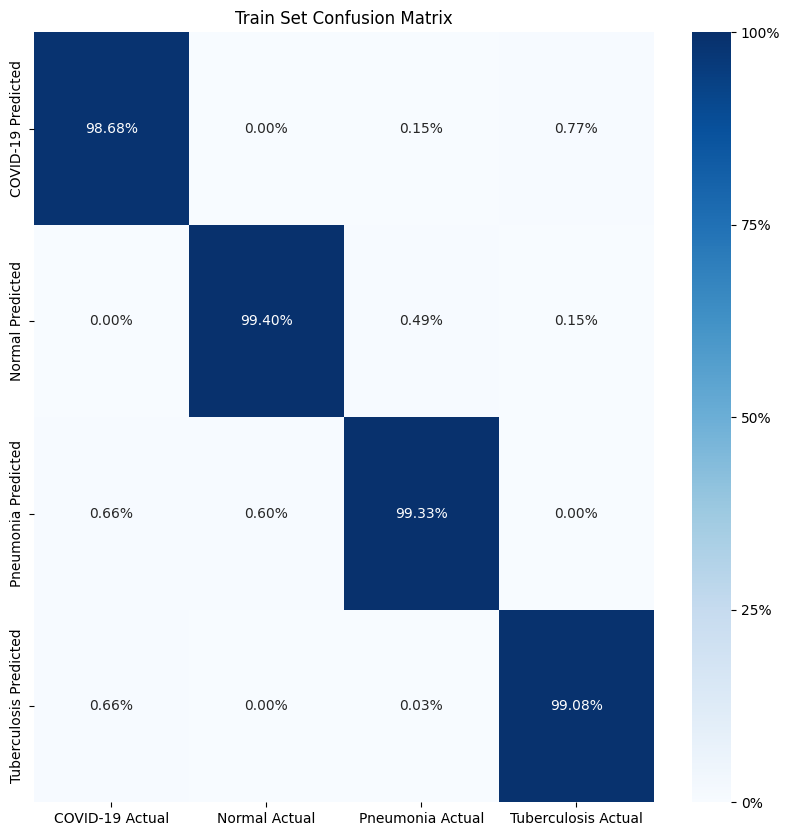

In [17]:
dashboard(grid_svc_accuracy, train_X, train_y, train=True)

Test Result: 
Accuracy Score: 99.62%
_______________________________________________
CLASSIFICATION REPORT:
            COVID-19      Normal  Pneumonia  Tuberculosis  accuracy  \
precision   1.000000    0.993789    0.99802      0.985507   0.99625   
recall      0.984848    0.993789    0.99802      1.000000   0.99625   
f1-score    0.992366    0.993789    0.99802      0.992701   0.99625   
support    66.000000  161.000000  505.00000     68.000000   0.99625   

            macro avg  weighted avg  
precision    0.994329      0.996268  
recall       0.994164      0.996250  
f1-score     0.994219      0.996250  
support    800.000000    800.000000  



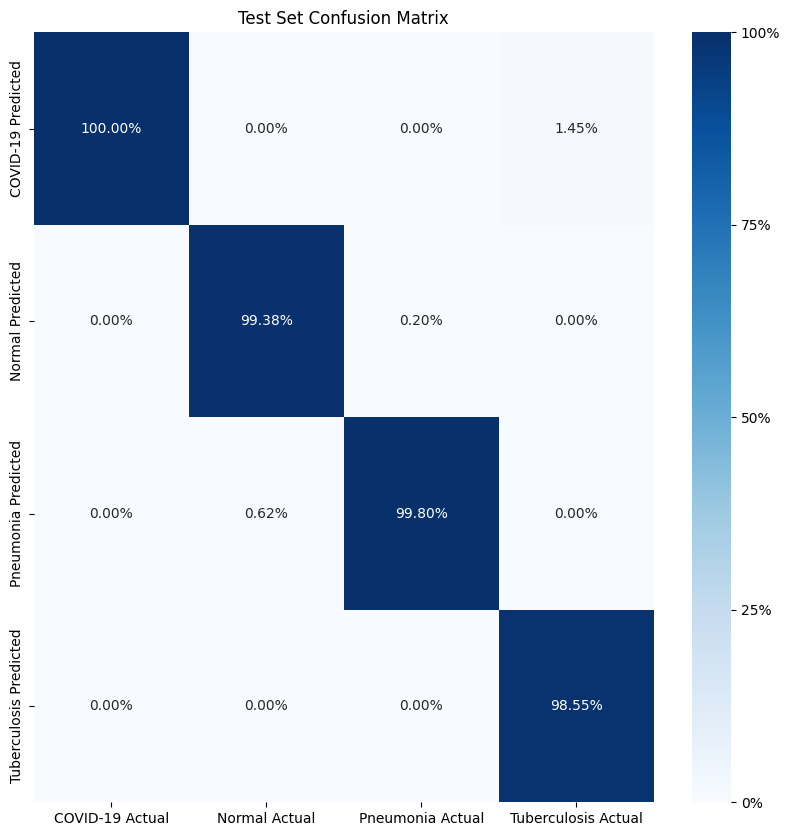

In [20]:
dashboard(grid_svc_accuracy, test_X, test_y)